In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [1]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-02 15-54-39.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30 
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-02 15-54-39_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_01.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1752109953.715973 22551040 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752109953.723264 22551451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752109953.728290 22551451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752109953.793229 22551447 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Detected FPS from PyAV: 60.0
-------- Detection Report --------
Total frames: 13174
Frames with at least 1 hand detected: 9450
Detection rate: 71.73%


In [16]:
df = pd.read_csv("hand_landmarks_07.csv")

print("Shape:", df.shape)
df

Shape: (394254, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.000000,Left,0,0.776412,0.974504,-1.739800e-07,1
1,0,0.000000,Left,1,0.739282,0.959243,-6.874622e-03,1
2,0,0.000000,Left,2,0.718967,0.904910,-8.789790e-04,1
3,0,0.000000,Left,3,0.711403,0.862149,9.189539e-03,1
4,0,0.000000,Left,4,0.709460,0.834671,2.266555e-02,1
...,...,...,...,...,...,...,...,...
394249,13173,219.566667,Left,16,0.773649,0.815535,-1.006215e-02,1
394250,13173,219.566667,Left,17,0.789506,0.875956,3.215445e-02,1
394251,13173,219.566667,Left,18,0.774589,0.843219,2.454042e-02,1
394252,13173,219.566667,Left,19,0.766609,0.828358,1.024440e-02,1


In [19]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()

In [22]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,0,0.000,Left,1,0.776412,0.739282,0.718967,0.711403,0.709460,0.753109,...,0.043602,0.053565,0.025184,0.038271,0.046617,0.052023,0.036925,0.046584,0.052228,0.056780
1,1,0.017,Left,1,0.776692,0.737426,0.716512,0.708769,0.707462,0.752081,...,0.030096,0.037532,0.018553,0.028712,0.034415,0.037689,0.029898,0.037000,0.040781,0.043757
2,2,0.033,Left,1,0.776199,0.736763,0.716045,0.707939,0.706668,0.752011,...,0.038411,0.046415,0.023119,0.035924,0.042315,0.045634,0.035204,0.044421,0.049063,0.052405
3,3,0.050,Left,1,0.775539,0.735999,0.714872,0.706518,0.705129,0.750968,...,0.034341,0.041764,0.019937,0.032219,0.038063,0.040684,0.032187,0.040696,0.044894,0.047762
4,4,0.067,Left,1,0.775742,0.736330,0.715097,0.706457,0.704570,0.751128,...,0.037855,0.045049,0.022655,0.035988,0.041544,0.043765,0.034933,0.044477,0.048771,0.051497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10820,13169,219.483,Left,1,0.826501,0.844445,0.842122,0.826297,0.811530,0.832680,...,0.010188,-0.003863,0.034211,0.028863,0.007492,-0.006897,0.034752,0.028379,0.014053,0.003333
10821,13170,219.500,Left,1,0.827448,0.844595,0.842802,0.827050,0.812295,0.832413,...,0.005565,-0.008198,0.030777,0.023789,0.002823,-0.010968,0.031173,0.023602,0.009588,-0.000651
10822,13171,219.517,Left,1,0.828330,0.846573,0.843718,0.826824,0.811550,0.833386,...,0.009135,-0.004837,0.033431,0.027471,0.006044,-0.008278,0.033877,0.026806,0.012176,0.001314
10823,13172,219.533,Left,1,0.828351,0.846000,0.843838,0.827793,0.812904,0.834412,...,0.007089,-0.006751,0.031753,0.025238,0.004345,-0.009517,0.032280,0.025084,0.011143,0.000856


In [27]:
df2 = pd.read_csv("hand_lable_07.csv")

print("Shape:", df.shape)
df2

Shape: (394254, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,7,2025-07-11 23:07:01.076,NaN,170.45,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,219.567,60.0,NaN,lift,NaN,START,40.250,D:/Data Science/UOB/DS_project/Full Study/07/2...,2415,NaN,NaN
1,7,2025-07-11 23:07:01.076,NaN,170.45,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,219.567,60.0,NaN,lift,NaN,STOP,40.967,D:/Data Science/UOB/DS_project/Full Study/07/2...,2458,NaN,NaN
2,7,2025-07-11 23:07:01.076,NaN,170.45,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,219.567,60.0,NaN,hold,NaN,START,40.983,D:/Data Science/UOB/DS_project/Full Study/07/2...,2459,NaN,NaN
3,7,2025-07-11 23:07:01.076,NaN,170.45,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,219.567,60.0,NaN,hold,NaN,STOP,43.000,D:/Data Science/UOB/DS_project/Full Study/07/2...,2580,NaN,NaN
4,7,2025-07-11 23:07:01.076,NaN,170.45,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,219.567,60.0,NaN,press,NaN,START,43.017,D:/Data Science/UOB/DS_project/Full Study/07/2...,2581,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,7,2025-07-11 23:07:01.076,NaN,170.45,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,219.567,60.0,NaN,hold,NaN,STOP,206.700,D:/Data Science/UOB/DS_project/Full Study/07/2...,12402,NaN,NaN
268,7,2025-07-11 23:07:01.076,NaN,170.45,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,219.567,60.0,NaN,rotate,NaN,START,206.717,D:/Data Science/UOB/DS_project/Full Study/07/2...,12403,NaN,NaN
269,7,2025-07-11 23:07:01.076,NaN,170.45,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,219.567,60.0,NaN,rotate,NaN,STOP,210.633,D:/Data Science/UOB/DS_project/Full Study/07/2...,12638,NaN,NaN
270,7,2025-07-11 23:07:01.076,NaN,170.45,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,219.567,60.0,NaN,hold,NaN,START,210.650,D:/Data Science/UOB/DS_project/Full Study/07/2...,12639,NaN,NaN


In [30]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,lift,40.250,40.967,2415,2458
1,hold,40.983,43.000,2459,2580
2,press,43.017,43.383,2581,2603
3,hold,43.400,43.733,2604,2624
4,press,43.750,44.133,2625,2648
...,...,...,...,...,...
131,hold,200.900,201.617,12054,12097
132,adjust,201.633,205.983,12098,12359
133,hold,206.000,206.700,12360,12402
134,rotate,206.717,210.633,12403,12638


In [33]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_83215/1143471531.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'lift' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,0,0.000,Left,1,0.776412,0.739282,0.718967,0.711403,0.709460,0.753109,...,0.053565,0.025184,0.038271,0.046617,0.052023,0.036925,0.046584,0.052228,0.056780,NaN
1,1,0.017,Left,1,0.776692,0.737426,0.716512,0.708769,0.707462,0.752081,...,0.037532,0.018553,0.028712,0.034415,0.037689,0.029898,0.037000,0.040781,0.043757,NaN
2,2,0.033,Left,1,0.776199,0.736763,0.716045,0.707939,0.706668,0.752011,...,0.046415,0.023119,0.035924,0.042315,0.045634,0.035204,0.044421,0.049063,0.052405,NaN
3,3,0.050,Left,1,0.775539,0.735999,0.714872,0.706518,0.705129,0.750968,...,0.041764,0.019937,0.032219,0.038063,0.040684,0.032187,0.040696,0.044894,0.047762,NaN
4,4,0.067,Left,1,0.775742,0.736330,0.715097,0.706457,0.704570,0.751128,...,0.045049,0.022655,0.035988,0.041544,0.043765,0.034933,0.044477,0.048771,0.051497,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10820,13169,219.483,Left,1,0.826501,0.844445,0.842122,0.826297,0.811530,0.832680,...,-0.003863,0.034211,0.028863,0.007492,-0.006897,0.034752,0.028379,0.014053,0.003333,NaN
10821,13170,219.500,Left,1,0.827448,0.844595,0.842802,0.827050,0.812295,0.832413,...,-0.008198,0.030777,0.023789,0.002823,-0.010968,0.031173,0.023602,0.009588,-0.000651,NaN
10822,13171,219.517,Left,1,0.828330,0.846573,0.843718,0.826824,0.811550,0.833386,...,-0.004837,0.033431,0.027471,0.006044,-0.008278,0.033877,0.026806,0.012176,0.001314,NaN
10823,13172,219.533,Left,1,0.828351,0.846000,0.843838,0.827793,0.812904,0.834412,...,-0.006751,0.031753,0.025238,0.004345,-0.009517,0.032280,0.025084,0.011143,0.000856,NaN


In [36]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
rotate    3737
NaN       2375
adjust    1699
other     1152
hold      1118
press      420
lift       246
place       78
Name: count, dtype: int64


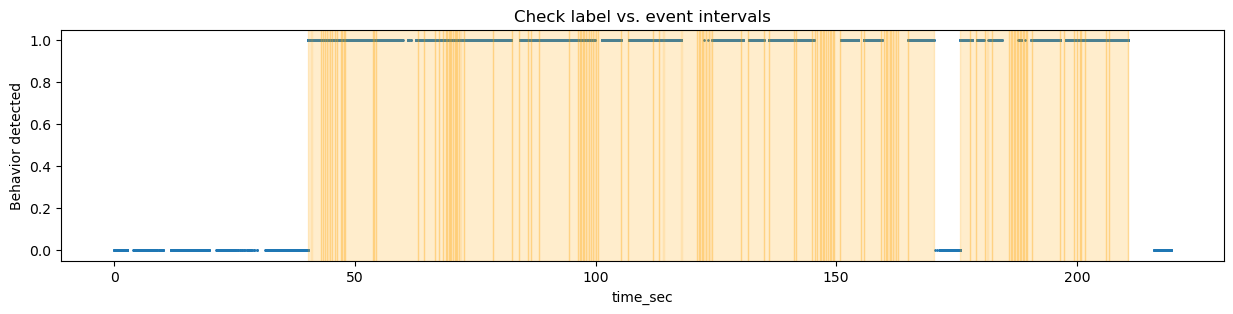

In [39]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()

In [42]:
df_wide[(df_wide['time_sec'] <= 100.583)][['time_sec', 'behavior']]

,time_sec,behavior
0,0.000,NaN
1,0.017,NaN
2,0.033,NaN
3,0.050,NaN
4,0.067,NaN
...,...,...
5564,99.733,hold
5565,99.750,hold
5566,99.767,hold
5567,99.783,press


In [44]:
df_wide[(df_wide['time_sec'] <= 124.25)][['time_sec', 'behavior']]

,time_sec,behavior
0,0.000,NaN
1,0.017,NaN
2,0.033,NaN
3,0.050,NaN
4,0.067,NaN
...,...,...
6436,117.733,adjust
6437,117.750,adjust
6438,122.633,press
6439,123.300,hold


In [51]:
df_wide[(df_wide['time_sec'] <= 161.85)][['time_sec', 'behavior']]

,time_sec,behavior
0,0.000,NaN
1,0.017,NaN
2,0.033,NaN
3,0.050,NaN
4,0.067,NaN
...,...,...
8215,159.250,adjust
8216,159.317,hold
8217,159.417,hold
8218,159.450,hold


In [54]:
df_clean = df_wide.dropna(subset=['behavior'])

df_wide = df_clean

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
1770,2415,40.250,Left,1,0.736983,0.724967,0.718010,0.700438,0.680883,0.758048,...,0.034402,0.062188,0.068686,0.049547,0.036243,0.079666,0.081290,0.070582,0.063024,lift
1771,2416,40.267,Left,1,0.739641,0.724661,0.716495,0.699032,0.678200,0.760220,...,0.021562,0.048839,0.052817,0.036937,0.026453,0.065908,0.067511,0.059439,0.054105,lift
1772,2417,40.283,Left,1,0.737111,0.724368,0.716137,0.698947,0.680101,0.760942,...,0.029668,0.055632,0.061155,0.044459,0.033253,0.072305,0.074733,0.065688,0.059500,lift
1773,2418,40.300,Left,1,0.742821,0.725993,0.717368,0.701262,0.685475,0.767290,...,0.045012,0.063711,0.072508,0.055163,0.042854,0.079509,0.082337,0.072689,0.066080,lift
1774,2419,40.317,Left,1,0.743975,0.725517,0.717556,0.703371,0.686937,0.765459,...,0.053928,0.067350,0.082269,0.068253,0.056937,0.084739,0.093873,0.087293,0.081907,lift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10610,12638,210.633,Right,1,0.067855,0.151516,0.228269,0.292067,0.345349,0.163671,...,-0.056127,-0.033964,-0.036957,-0.019593,-0.002604,0.028266,0.032735,0.043710,0.056275,rotate
10611,12639,210.650,Left,1,0.648636,0.622807,0.595455,0.559741,0.531930,0.597647,...,0.043290,0.062778,0.069382,0.056142,0.047291,0.073897,0.078563,0.072393,0.067985,hold
10612,12640,210.667,Left,1,0.650025,0.621441,0.594118,0.561288,0.535213,0.596363,...,0.040536,0.064100,0.069052,0.053919,0.044105,0.076485,0.079513,0.071739,0.066353,hold
10613,12641,210.683,Left,1,0.641664,0.608456,0.582325,0.550244,0.524308,0.589357,...,0.056606,0.080105,0.090899,0.071478,0.057297,0.093510,0.099583,0.088189,0.079026,hold


In [57]:
df_wide['dataset_id'] = '07'

cols = df_wide.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide = df_wide[cols]

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_83215/4167387954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wide['dataset_id'] = '07'


,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
1770,07,2415,40.250,Left,1,0.736983,0.724967,0.718010,0.700438,0.680883,...,0.034402,0.062188,0.068686,0.049547,0.036243,0.079666,0.081290,0.070582,0.063024,lift
1771,07,2416,40.267,Left,1,0.739641,0.724661,0.716495,0.699032,0.678200,...,0.021562,0.048839,0.052817,0.036937,0.026453,0.065908,0.067511,0.059439,0.054105,lift
1772,07,2417,40.283,Left,1,0.737111,0.724368,0.716137,0.698947,0.680101,...,0.029668,0.055632,0.061155,0.044459,0.033253,0.072305,0.074733,0.065688,0.059500,lift
1773,07,2418,40.300,Left,1,0.742821,0.725993,0.717368,0.701262,0.685475,...,0.045012,0.063711,0.072508,0.055163,0.042854,0.079509,0.082337,0.072689,0.066080,lift
1774,07,2419,40.317,Left,1,0.743975,0.725517,0.717556,0.703371,0.686937,...,0.053928,0.067350,0.082269,0.068253,0.056937,0.084739,0.093873,0.087293,0.081907,lift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10610,07,12638,210.633,Right,1,0.067855,0.151516,0.228269,0.292067,0.345349,...,-0.056127,-0.033964,-0.036957,-0.019593,-0.002604,0.028266,0.032735,0.043710,0.056275,rotate
10611,07,12639,210.650,Left,1,0.648636,0.622807,0.595455,0.559741,0.531930,...,0.043290,0.062778,0.069382,0.056142,0.047291,0.073897,0.078563,0.072393,0.067985,hold
10612,07,12640,210.667,Left,1,0.650025,0.621441,0.594118,0.561288,0.535213,...,0.040536,0.064100,0.069052,0.053919,0.044105,0.076485,0.079513,0.071739,0.066353,hold
10613,07,12641,210.683,Left,1,0.641664,0.608456,0.582325,0.550244,0.524308,...,0.056606,0.080105,0.090899,0.071478,0.057297,0.093510,0.099583,0.088189,0.079026,hold


In [60]:
df_wide.to_csv("handlandmark_wide_07.csv", index=False)